In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud

In [3]:
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [5]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization

In [7]:
import os
import re
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/clean-dataset-steam/test.csv
/kaggle/input/clean-dataset-steam/train.csv
/kaggle/input/glove42b300dtxt/glove.42B.300d.txt
/kaggle/input/steam-recommendation-nlp-dataset/game_overview.csv
/kaggle/input/steam-recommendation-nlp-dataset/test.csv
/kaggle/input/steam-recommendation-nlp-dataset/train.csv


In [8]:
df = pd.read_csv('/kaggle/input/clean-dataset-steam/train.csv')
game_df = pd.read_csv('/kaggle/input/steam-recommendation-nlp-dataset/game_overview.csv')
testing_df=  pd.read_csv('/kaggle/input/clean-dataset-steam/test.csv')

In [9]:
def rep(text):
    text = re.sub('♥♥♥♥',"",text)
    return text

df['user_review']=df.user_review.apply(rep)
testing_df['user_review']=testing_df.user_review.apply(rep)

In [10]:
# testing_df['user_review'].sample(5)

In [11]:
def low(text):
    return text.lower()

df['user_review']=df.user_review.apply(low)
testing_df['user_review']=testing_df.user_review.apply(low)

# testing_df.head(5)

In [12]:
def asc(text):
    text = re.sub('[^a-zA-Z.,]'," ",text)
    return text

df['user_review']=df.user_review.apply(asc)
testing_df['user_review']=testing_df.user_review.apply(asc)


# testing_df.head(5)

In [13]:
def space(text):
#     text = re.sub(' +', ' ', text)
    text = " ".join(text.split())
    return text

df['user_review']=df.user_review.apply(space)
testing_df['user_review']=testing_df.user_review.apply(space)

In [14]:
def clean(text):
    text = re.sub(' ll', 'will', text)
    text = re.sub('lvl', 'level', text)
    text = re.sub('dev', 'developer', text)
#     text = re.sub('ll', 'will', text)

    return text

df['user_review']=df.user_review.apply(clean)
testing_df['user_review']=testing_df.user_review.apply(clean)

In [15]:
testing_df['user_review'][2445]

'till level you are like wtf how can this game get so many negative reviews then surprise after level all makes sensethe game is boring and lazy, the developers dont pay attetion to the community.all this game has to offer is classes nothing more, i m not saying that the classes are bad but thats only it, a class simulator. dungeons oh boy haha, that if you like pve you should run now.dungeons can be done only times per day if you have your token active. wtf market of the game is bs, you can place max items with active token. wtf haters will say anti bot bro shut up you that is what i call bad developer.all you do in this game is grind or quests, nothing more. my friends for a game released in thats so bad that makes me cry, i know some people like that type of game but itwill fail coz its and not , if imc wants to get more people to play they need to adapt.tl dr run dont download or support this game till imc learn to do what the community wants. but ignore all i said if you want a ga

# let's summarize

In [16]:
# import networkx as nx
# from sklearn.metrics.pairwise import cosine_similarity
# gloveFile = "/kaggle/input/glove42b300dtxt/glove.42B.300d.txt"
# dim=300

In [17]:
# def loadGloveModel(gloveFile):
#     word_embeddings = {}
#     f = open(gloveFile, encoding='utf-8')
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         word_embeddings[word] = coefs
#     f.close()
#     return word_embeddings

# word_embeddings = loadGloveModel(gloveFile)
# print("Vocab Size = ",len(word_embeddings))


In [18]:
# def summ(text):
#     sentences = sent_tokenize(text)
    
#     sentence_vectors = []
#     for i in sentences:
#         if len(i)!=0:
#             v = sum([word_embeddings.get(w, np.zeros((dim,))) for w in i.split()])/(len(i.split())+0.001)
#         else:
#             v = np.zeros((dim,))
#         sentence_vectors.append(v)
        
#     sim_mat = np.zeros([len(sentences),len(sentences)])
    
#     for i in range(len(sentences)):
#         for j in range(len(sentences)):
#             if i!=j:
#                 sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,dim),sentence_vectors[j].reshape(1,dim))[0,0]

#     sim_mat = np.round(sim_mat,3)
#     nx_graph = nx.from_numpy_array(sim_mat)
#     scores = nx.pagerank(nx_graph)
#     ranked_sentences = sorted(((scores[i],i)for i,s in enumerate(sentences)),reverse=True)
#     arranged_sentences = sorted(ranked_sentences[0:int(len(sentences)*0.5)] , key=lambda x:x[1])
# #     print("\n".join([sentences[x[1]] for x in arranged_sentences]))
#     text = " ".join([sentences[x[1]] for x in arranged_sentences])
#     return text

In [19]:
# testing_df['user_review'][2445]

In [20]:
# pip install bert-extractive-summarizer

In [21]:
# from summarizer import Summarizer

In [22]:
# def summary(text):
#     model = Summarizer()
#     result = model(body)
#     text = ''.join(result)
#     return text

# df['user_review']=df.user_review.apply(summary)
# # testing_df['user_review']=testing_df.user_review.apply(clean)

# summary not working

In [23]:
testing_df.drop(["review_id","title","year"],axis=1,inplace=True)

In [24]:
testing_df.head(5)

,user_review
0,"nice graphics, new maps, weapons and models. b..."
1,i would not recommend getting into this at its...
2,edit i have tried playing cs go recently and i...
3,the game is great. but the community is the wo...
4,i thank trulyrazor for buying this for me a lo...


In [25]:
df.drop(['review_id'],axis=1,inplace=True)

In [26]:
result = pd.merge(df, game_df,on='title', how='left')

In [27]:
result.drop(['year'],axis=1,inplace=True)
result.tail(5)

,title,user_review,user_suggestion,developer,publisher,tags,overview
17489,EverQuest II,arguably the single greatest mmorp that exists...,1,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...
17490,EverQuest II,"an older game, to be sure, but has its own cha...",1,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...
17491,EverQuest II,when i frist started playing everquest it was ...,1,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...
17492,EverQuest II,cool game. the only thing that really pisses m...,1,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...
17493,EverQuest II,"this game since i was a little kid, always hav...",1,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...


In [28]:
result.isnull().any()

title              False
user_review        False
user_suggestion    False
developer          False
publisher          False
tags               False
overview           False
dtype: bool

In [29]:
result.drop(["overview","developer","publisher"],axis=1,inplace=True)

In [30]:
result.head(2)

,title,user_review,user_suggestion,tags
0,Spooky's Jump Scare Mansion,i m scared and hearing creepy voices. so iwill...,1,"['Horror', 'Free to Play', 'Cute', 'First-Pers..."
1,Spooky's Jump Scare Mansion,"best game, more better than sam pepper s youtu...",1,"['Horror', 'Free to Play', 'Cute', 'First-Pers..."


In [31]:
testing_df.head(2)

,user_review
0,"nice graphics, new maps, weapons and models. b..."
1,i would not recommend getting into this at its...


# Text Processing

In [32]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [33]:
result['user_review'] = result['user_review'].apply(punctuation_removal)
testing_df['user_review'] = testing_df['user_review'].apply(punctuation_removal)


In [34]:
testing_df.user_review.str.len().mean()

748.372156619018

In [35]:
result.user_review.str.len().mean()

726.3807591174117

In [36]:

# from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
# stop = stopwords.words('english')

In [37]:
# stop.remove('not')
# stop.remove("don't")

In [38]:
# stop_words = []

# for item in stop: 
#     new_item = punctuation_removal(item)
#     stop_words.append(new_item) 
# print(stop_words)

In [39]:
# def stopwords_removal(messy_str):
#     messy_str = word_tokenize(messy_str)
#     return [word.lower() for word in messy_str 
#             if word.lower() not in stop_words ]

In [40]:
# result['user_review'] = result['user_review'].apply(stopwords_removal)
# testing_df['user_review'] = testing_df['user_review'].apply(stopwords_removal)


In [41]:
# result.head(2)



In [42]:
# import re
# def drop_numbers(list_text):
#     list_text_new = []
#     for i in list_text:
#         if not re.search('\d', i):
#             list_text_new.append(i)
#     return ' '.join(list_text_new)
# result['user_review'] = result['user_review'].apply(drop_numbers)
# testing_df['user_review'] = testing_df['user_review'].apply(drop_numbers)


In [43]:
# result.head(2)

In [44]:
# from textblob import TextBlob
# example = "This game is scary and i would recommend it playing"
# blob = TextBlob(example)
# blob.sentiment

#Note that the subjectivity is still high as it is still an opinion and not a fact

In [45]:
# result_reviews = result['user_review'] 
# testing_reviews = testing_df['user_review'] 

# from tqdm import tqdm
# result_sentiments = []
# for review in tqdm(result_reviews):
#     blob = TextBlob(review)
#     result_sentiments += [blob.sentiment.polarity]
    
    
# from tqdm import tqdm
# testing_sentiments = []
# for review in tqdm(testing_reviews):
#     blob = TextBlob(review)
#     testing_sentiments += [blob.sentiment.polarity]
    
    
# result['sentiment'] = result_sentiments
# testing_df['sentiment'] =testing_sentiments




# loaded_submission = pd.read_csv('/kaggle/input/submission/submission1.csv')
# loaded_submission.tail()
# loaded_submission['sentiment'] = testing_df['sentiment']



# result.user_review[13978] = "good game"

# result.user_review[13978]

In [46]:
# result.sample(20)

# Correlation with ratings

Let's see if the newly calculated sentiments have any correlation with the ratings. Our hypothesis would be that reviews with postive reviews would have higher polarity values and vice-versa.

In [47]:
# np.corrcoef(result["user_suggestion"], result["sentiment"])

We observe that there is indeed a positive but not very strong correlation between the sentiment of the reviews and the ratings given (0.378). Although the correlation is weak, it is still a useful feature for us to make predictions from as it isn't close to 0.

# Visualizing the correlation

In [48]:
# sns.boxplot(x=np.array(result["user_suggestion"]),y=np.array(result["sentiment"]))
# plt.xlabel("Recommended")
# plt.ylabel("Sentiment")
# plt.title("Sentiment vs Recommended")
# plt.show()

Improving the sentiment analysis
This was a very simple intro to sentiment analysis. We note that the sentiments calculated are only weakly correlated with the ratings, suggesting that there is a lot of room for improvement. A few basic steps that can be taken to improve our sentiment calculation are:

Pre-processing: Clean up the text. Do stemming/lemmatization. Remove stop words
Remove neutral sentences - Do sentiment analysis of individual sentences in a review and remove neutral ones. Then re-run the sentiment analysis on the polar sentences. This will give a more accurate sentiment score

In [49]:
# result.drop(['title','tags'],axis=1,inplace=True)
# result.head(2)

In [50]:
# result.sentiment.min()

In [51]:
# result.sentiment.max()

In [52]:
X = result.drop('user_suggestion',axis=1)
y = result['user_suggestion']

In [53]:
X.user_review.str.len().mean()

726.3807591174117

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 42, test_size=0.25)

In [55]:
print('\n train X: {} \n train y: {} \n Val X: {} \n val y: {}'.format((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape)))


 train X: (13120, 3) 
 train y: (13120,) 
 Val X: (4374, 3) 
 val y: (4374,)


In [56]:
X_train.user_review.str.len().mean()

726.2573170731707

In [57]:
X_test.user_review.str.len().mean()

726.7510288065844

# BERT

In [58]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [59]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [60]:
X_train_bert = X_train.user_review
X_test_bert = X_test.user_review



In [61]:
# from tqdm import tqdm
# train_x_sentiment = []
# for review in tqdm(X_train_bert):
#     blob = TextBlob(review)
#     train_x_sentiment += [blob.sentiment.polarity]

In [62]:
# from tqdm import tqdm
# test_x_sentiment = []
# for review in tqdm(X_test_bert):
#     blob = TextBlob(review)
#     test_x_sentiment += [blob.sentiment.polarity]

In [63]:
# X_train_bert

In [64]:
# X_train_bert.head(2)

In [65]:
def bert_encode(input_text, tokenizer, max_len = 512):
    token_input = [] 
    mask_input = []
    seg_input = []
    
    for text in input_text:
        text = tokenizer.tokenize(text)
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)      
        token_input.append(tokens + [0]*pad_len)
        mask_input.append([1]*len(input_sequence) + [0]*pad_len)
        seg_input.append([0] * max_len)
        
    return np.array(token_input), np.array(mask_input), np.array(seg_input)

In [66]:
def build_model(bert_layer, max_len = 512):
    input_word_ids = Input(shape=(max_len, ),dtype = tf.int32,name = 'input_words_ids')
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [67]:
# X_train_bert.user_review.str.len()

In [68]:
# mean_len = X_train_bert.user_review.str.len().mean()

In [69]:
# mean_len

In [70]:
# X_test_bert.user_review.str.len().mean()

In [71]:
# X_train_bert = pd.Series(X_train_bert)
# X_test_bert =pd.Series(X_test_bert)

In [72]:
type(X_train_bert)

pandas.core.series.Series

In [73]:
train_input = bert_encode(X_train_bert.values, tokenizer, max_len=400)
test_input = bert_encode(X_test_bert.values, tokenizer, max_len=400)
train_labels = y_train.values

In [74]:
testing_input = bert_encode(testing_df.user_review, tokenizer, max_len=400)

In [75]:
model = build_model(bert_layer, max_len=400)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words_ids (InputLayer)    [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 400)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 400)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_words_ids[0][0]            
                                                                 input_mask[0][0]             

In [76]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.1,
    epochs=3,
    batch_size=5
)

Train on 11808 samples, validate on 1312 samples
Epoch 1/3
11808/11808 [==============================] - 2131s 180ms/sample - loss: 0.3120 - accuracy: 0.8637 - val_loss: 0.2285 - val_accuracy: 0.9116
Epoch 2/3
11808/11808 [==============================] - 2086s 177ms/sample - loss: 0.1574 - accuracy: 0.9413 - val_loss: 0.2245 - val_accuracy: 0.9154
Epoch 3/3
11808/11808 [==============================] - 2085s 177ms/sample - loss: 0.0495 - accuracy: 0.9848 - val_loss: 0.2933 - val_accuracy: 0.9116


In [77]:
prediction = model.predict(test_input)
preds = []
for x in prediction:
    preds.append(int(x.round()))

from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_test.values,preds))

Accuracy:  0.9108367626886146


In [78]:
from sklearn.metrics import confusion_matrix 

print(confusion_matrix(y_test.values, preds))

[[1626  216]
 [ 174 2358]]


In [79]:
preds.count(1)

2574

In [80]:
preds.count(0)

1800

[[1626  216]
 [ 174 2358]]


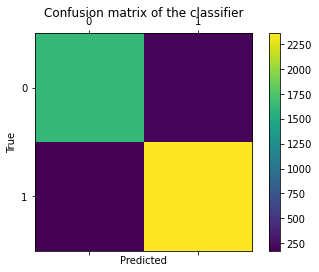

In [81]:
labels = [0, 1]
cm = confusion_matrix(y_test.values, preds, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [82]:
from sklearn.metrics import classification_report 
print(classification_report(y_test.values, preds))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1842
           1       0.92      0.93      0.92      2532

    accuracy                           0.91      4374
   macro avg       0.91      0.91      0.91      4374
weighted avg       0.91      0.91      0.91      4374



In [83]:
# train_history = model.fit(
#     train_input, train_labels,
#     validation_split=0.1,
#     epochs=1,
#     batch_size=5
# )

In [84]:
# prediction = model.predict(test_input)
# preds = []
# for x in prediction:
#     preds.append(int(x.round()))

# from sklearn.metrics import accuracy_score
# print("Accuracy: ", accuracy_score(y_test.values,preds))

In [ ]:
pred_result = prediction = model.predict(testing_input)
submission = pred_result.round().astype(int)
submission=pd.DataFrame(submission)

sub = pd.read_csv('/kaggle/input/steam-recommendation-nlp-dataset/test.csv')
submission['review_id']=sub['review_id']

submission= submission[['review_id',0]]
submission.rename(columns = {0:'user_suggestion'}, inplace = True) 

submission.head(4)



In [ ]:
submission.to_csv('submission_400_clean.csv', index=False)

# Experiment

In [ ]:
# X

In [ ]:
# super_train = bert_encode(X.user_review.values, tokenizer, max_len=380)

In [ ]:
# super_prediction = model.predict(super_train)
# super_pred = []
# for x in super_prediction:
#     super_pred.append(int(x.round()))



In [ ]:
# len(super_pred)

In [ ]:
# from sklearn.metrics import accuracy_score
# print("Accuracy: ", accuracy_score(super_pred, y.values))

# now adding sentiment to it

In [ ]:
# from tqdm import tqdm
# super_sentiment = []
# for review in tqdm(X.user_review.values):
#     blob = TextBlob(review)
#     super_sentiment += [blob.sentiment.polarity]

In [ ]:
# def num(x):
#     if x >= 0:
#         return 1
#     elif x <= 0:
#         return -1

In [ ]:
# super_dataset = pd.DataFrame(super_pred)
# super_dataset['sentiment']=super_sentiment
# super_dataset['Target']=y.values

In [ ]:
# super_dataset.tail(10)

In [ ]:
# super_dataset['sentiment']=super_dataset.sentiment.apply(num)

In [ ]:
# super_dataset.sample(10)

In [ ]:
# super_dataset.shape

In [ ]:
# X_super= super_dataset.drop(['Target'],axis=1)
# y_super = super_dataset.Target

In [ ]:
# from sklearn.model_selection import train_test_split

# X_train_super, X_test_super, y_train_super, y_test_super = train_test_split(X_super, y_super, test_size = 0.30, random_state = 0)

In [ ]:
# print(X_train_super.shape)
# print(X_test_super.shape)

In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# X_train_super = pd.DataFrame(scaler.fit_transform(X_train_super), columns = X_super.columns)

# X_test_super = pd.DataFrame(scaler.transform(X_test_super), columns = X_super.columns)

In [ ]:
# X_train_super.head()

In [ ]:
# from sklearn.metrics import accuracy_score

In [ ]:
# from sklearn.linear_model import LogisticRegression

# clf = LogisticRegression(max_iter=200, )
# clf.fit(X_train_super, y_train_super)
# y_pred_super = clf.predict(X_test_super)

# print('LogisticRegression accuracy_score {0:0.4f}'. format(accuracy_score(y_test_super, y_pred_super)))
# clf.score(X_train_super, y_train_super)

In [ ]:
# from xgboost import XGBClassifier

# clf= XGBClassifier(learning_rate=0.04, n_estimators=406, max_depth=5,
#                         min_child_weight=4, 
#                          seed=27)
# clf.fit(X_train_super, y_train_super)
# y_pred_super = clf.predict(X_test_super)

# print('XGBClassifier accuracy_score {0:0.4f}'. format(accuracy_score(y_test_super, y_pred_super)))
# clf.score(X_train_super, y_train_super)

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# clf = DecisionTreeClassifier( max_depth=5)
# clf.fit(X_train_super, y_train_super)
# y_pred_super = clf.predict(X_test_super)

# print('DecisionTreeClassifier accuracy_score {0:0.4f}'. format(accuracy_score(y_test_super, y_pred_super)))
# clf.score(X_train_super, y_train_super)

In [ ]:
# from catboost import CatBoostClassifier
# clf= CatBoostClassifier( iterations=100,
#                 learning_rate =0.05,
#                  max_depth=4,
#                  leaf_estimation_iterations=20)
# clf.fit(X_train_super, y_train_super)
# y_pred_super = clf.predict(X_test_super)

# print('CatBoostClassifier accuracy_score {0:0.4f}'. format(accuracy_score(y_test_super, y_pred_super)))
# clf.score(X_train_super, y_train_super)

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier
# clf= GradientBoostingClassifier(                          
#     )
# clf.fit(X_train_super, y_train_super)
# y_pred_super = clf.predict(X_test_super)

# print('GradientBoostingClassifier accuracy_score {0:0.4f}'. format(accuracy_score(y_test_super, y_pred_super)))
# clf.score(X_train_super, y_train_super)

In [ ]:
# from sklearn.ensemble import BaggingClassifier
# clf= BaggingClassifier(#base_estimator=base_cls,
#     n_estimators=400,
#    )
# clf.fit(X_train_super, y_train_super)
# y_pred_super = clf.predict(X_test_super)

# print('BaggingClassifier accuracy_score {0:0.4f}'. format(accuracy_score(y_test_super, y_pred_super)))
# clf.score(X_train_super, y_train_super)

In [ ]:
# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.ensemble import HistGradientBoostingClassifier

# clf= HistGradientBoostingClassifier( #loss='binary_crossentropy',
#     learning_rate=0.05,
# #     max_iter=6000,
#     max_depth=6,
# #     max_leaf_nodes=5,
#    )
# clf.fit(X_train_super, y_train_super)
# y_pred_super = clf.predict(X_test_super)

# print('HistGradientBoostingClassifier accuracy_score {0:0.4f}'. format(accuracy_score(y_test_super, y_pred_super)))
# clf.score(X_train_super, y_train_super)

In [ ]:
# from lightgbm import LGBMClassifier

# clf= LGBMClassifier(# bagging_freq = 5,
#     bagging_fraction = 1,
#     boost_from_average= 'true',
#     boost =  'gbdt',
# #     feature_fraction =  0.01,
#     learning_rate =  0.05,
# #     max_depth =  15,  
# #     metric = log_loss,
#     min_data_in_leaf =  10,
#     min_sum_hessian_in_leaf =  0.05,
#     num_leaves =  14,
# #     num_threads =  8,
#     tree_learner =  'serial',
#     verbosity =  1
#                    )
# clf.fit(X_train_super, y_train_super)
# y_pred_super = clf.predict(X_test_super)

# print('LGBMClassifier accuracy_score {0:0.4f}'. format(accuracy_score(y_test_super, y_pred_super)))
# clf.score(X_train_super, y_train_super)

# Testing DataFrame Super_output

In [ ]:
# submission_super=pd.DataFrame(submission)

In [ ]:
# submission_super.drop("review_id",axis=1,inplace=True)

In [ ]:
# submission_super.head()

In [ ]:
# submission_super.shape

In [ ]:
# from tqdm import tqdm
# submission_super_sentiment = []
# for review in tqdm(testing_df.user_review.values):
#     blob = TextBlob(review)
#     submission_super_sentiment += [blob.sentiment.polarity]

In [ ]:
# len(submission_super_sentiment)

In [ ]:
# submission_super['sentiment']=submission_super_sentiment

In [ ]:
# submission_super.head()

In [ ]:
# submission_super['sentiment']=submission_super.sentiment.apply(num)

In [ ]:
# submission_super = pd.DataFrame(scaler.transform(submission_super), columns = submission_super.columns)

In [ ]:
# submission_super.rename(columns = {'user_suggestion':0}, inplace = True) 
# submission_super.head()

# saving the super submission

In [ ]:
# X_test_super

In [ ]:
# super_predictions = clf.predict(submission_super)

In [ ]:
# sss = pd.read_csv('/kaggle/input/steam-recommendation-nlp-dataset/test.csv')

In [ ]:
# result_data_df = pd.DataFrame(sss.review_id)

In [ ]:
# result_data_df['user_suggestion']=super_predictions

In [ ]:
# result_data_df.head()

In [ ]:
# result_data_df.to_csv('exp21.csv', index=False)

# Experiment End

# Saving Output by BerT

In [ ]:
# pred_result = prediction = model.predict(testing_input)
# submission = pred_result.round().astype(int)
# submission=pd.DataFrame(submission)

# sub = pd.read_csv('/kaggle/input/steam-recommendation-nlp-dataset/test.csv')
# submission['review_id']=sub['review_id']

# submission= submission[['review_id',0]]
# submission.rename(columns = {0:'user_suggestion'}, inplace = True) 

# submission.head(4)

# submission.to_csv('submission_91.csv', index=False)